In [30]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [31]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [32]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (2*(Euv))
        self.beta = (1-eta)*self.beta + eta * (2*Ev)
        
        self.eta = eta * 0.99


class Net(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(Net, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

In [33]:
def train_deep_model(network, optimization, seed):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10

int_lr = 0.3
syn_lr = 0.03

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = Net(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = Net(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = Net(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = Net(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 0.467
[1,   200] loss: 0.215
[1,   300] loss: 0.195
[2,   100] loss: 0.147
[2,   200] loss: 0.149
[2,   300] loss: 0.144
[3,   100] loss: 0.121
[3,   200] loss: 0.118
[3,   300] loss: 0.112
[4,   100] loss: 0.093
[4,   200] loss: 0.102
[4,   300] loss: 0.115
[5,   100] loss: 0.089
[5,   200] loss: 0.105
[5,   300] loss: 0.103
[6,   100] loss: 0.091
[6,   200] loss: 0.080
[6,   300] loss: 0.089
[7,   100] loss: 0.085
[7,   200] loss: 0.084
[7,   300] loss: 0.086
[8,   100] loss: 0.070
[8,   200] loss: 0.071
[8,   300] loss: 0.082
[9,   100] loss: 0.065
[9,   200] loss: 0.073
[9,   300] loss: 0.076
[10,   100] loss: 0.059
[10,   200] loss: 0.068
[10,   300] loss: 0.080
[11,   100] loss: 0.052
[11,   200] loss: 0.064
[11,   300] loss: 0.069
[12,   100] loss: 0.056
[12,   200] loss: 0.070
[12,   300] loss: 0.072
[13,   100] loss: 0.046
[13,   200] loss: 0.055
[13,   300] loss: 0.066
[14,   100] loss: 0.048
[14,   200] loss: 0.060
[14,   300] loss: 0.056
[15

[14,   200] loss: 0.224
[14,   300] loss: 0.227
[15,   100] loss: 0.218
[15,   200] loss: 0.244
[15,   300] loss: 0.226
[16,   100] loss: 0.236
[16,   200] loss: 0.255
[16,   300] loss: 0.218
[17,   100] loss: 0.233
[17,   200] loss: 0.241
[17,   300] loss: 0.246
[18,   100] loss: 0.239
[18,   200] loss: 0.254
[18,   300] loss: 0.250
[19,   100] loss: 0.234
[19,   200] loss: 0.212
[19,   300] loss: 0.241
[20,   100] loss: 0.214
[20,   200] loss: 0.213
[20,   300] loss: 0.204
Finished training!

Training IP Net
[1,   100] loss: 0.701
[1,   200] loss: 0.249
[1,   300] loss: 0.192
[2,   100] loss: 0.154
[2,   200] loss: 0.152
[2,   300] loss: 0.144
[3,   100] loss: 0.115
[3,   200] loss: 0.120
[3,   300] loss: 0.117
[4,   100] loss: 0.104
[4,   200] loss: 0.106
[4,   300] loss: 0.113
[5,   100] loss: 0.083
[5,   200] loss: 0.088
[5,   300] loss: 0.097
[6,   100] loss: 0.077
[6,   200] loss: 0.076
[6,   300] loss: 0.095
[7,   100] loss: 0.078
[7,   200] loss: 0.079
[7,   300] loss: 0.079
[

[7,   100] loss: 0.434
[7,   200] loss: 0.430
[7,   300] loss: 0.445
[8,   100] loss: 0.442
[8,   200] loss: 0.439
[8,   300] loss: 0.462
[9,   100] loss: 0.428
[9,   200] loss: 0.448
[9,   300] loss: 0.442
[10,   100] loss: 0.436
[10,   200] loss: 0.428
[10,   300] loss: 0.455
[11,   100] loss: 0.440
[11,   200] loss: 0.447
[11,   300] loss: 0.440
[12,   100] loss: 0.433
[12,   200] loss: 0.447
[12,   300] loss: 0.434
[13,   100] loss: 0.428
[13,   200] loss: 0.422
[13,   300] loss: 0.418
[14,   100] loss: 0.412
[14,   200] loss: 0.430
[14,   300] loss: 0.423
[15,   100] loss: 0.430
[15,   200] loss: 0.428
[15,   300] loss: 0.425
[16,   100] loss: 0.430
[16,   200] loss: 0.445
[16,   300] loss: 0.440
[17,   100] loss: 0.443
[17,   200] loss: 0.431
[17,   300] loss: 0.470
[18,   100] loss: 0.432
[18,   200] loss: 0.447
[18,   300] loss: 0.440
[19,   100] loss: 0.423
[19,   200] loss: 0.432
[19,   300] loss: 0.430
[20,   100] loss: 0.422
[20,   200] loss: 0.431
[20,   300] loss: 0.451
F

[20,   200] loss: 0.047
[20,   300] loss: 0.046
Finished training!

Training Standard Net
[1,   100] loss: 0.591
[1,   200] loss: 0.286
[1,   300] loss: 0.306
[2,   100] loss: 0.245
[2,   200] loss: 0.260
[2,   300] loss: 0.272
[3,   100] loss: 0.258
[3,   200] loss: 0.267
[3,   300] loss: 0.261
[4,   100] loss: 0.246
[4,   200] loss: 0.239
[4,   300] loss: 0.262
[5,   100] loss: 0.249
[5,   200] loss: 0.253
[5,   300] loss: 0.249
[6,   100] loss: 0.235
[6,   200] loss: 0.221
[6,   300] loss: 0.238
[7,   100] loss: 0.223
[7,   200] loss: 0.235
[7,   300] loss: 0.221
[8,   100] loss: 0.239
[8,   200] loss: 0.213
[8,   300] loss: 0.231
[9,   100] loss: 0.217
[9,   200] loss: 0.249
[9,   300] loss: 0.236
[10,   100] loss: 0.226
[10,   200] loss: 0.234
[10,   300] loss: 0.236
[11,   100] loss: 0.223
[11,   200] loss: 0.245
[11,   300] loss: 0.243
[12,   100] loss: 0.233
[12,   200] loss: 0.239
[12,   300] loss: 0.218
[13,   100] loss: 0.224
[13,   200] loss: 0.225
[13,   300] loss: 0.251
[

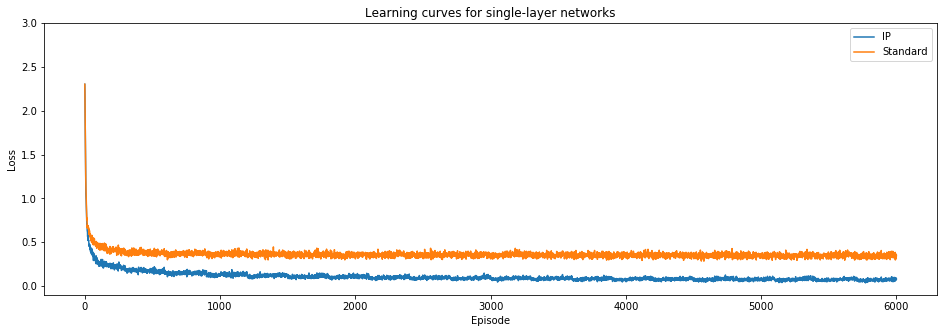

In [34]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for single-layer networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = net(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the standard network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = IPnet(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the IP network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

Accuracy of the standard network on the 10000 test images: 58.0000 %
Accuracy of the IP network on the 10000 test images: 96.4900 %


In [24]:
class CNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

In [35]:
batchSize = 200

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150

test_runs = 10

int_lr = 0.3
syn_lr = 0.01

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = CNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 1.926
[1,   200] loss: 1.756
[2,   100] loss: 1.607
[2,   200] loss: 1.547
[3,   100] loss: 1.461
[3,   200] loss: 1.460
[4,   100] loss: 1.364
[4,   200] loss: 1.400
[5,   100] loss: 1.305
[5,   200] loss: 1.329
[6,   100] loss: 1.248
[6,   200] loss: 1.263
[7,   100] loss: 1.189
[7,   200] loss: 1.228
[8,   100] loss: 1.141
[8,   200] loss: 1.191
[9,   100] loss: 1.099
[9,   200] loss: 1.142
[10,   100] loss: 1.060
[10,   200] loss: 1.099
[11,   100] loss: 1.015
[11,   200] loss: 1.066
[12,   100] loss: 0.983
[12,   200] loss: 1.025
[13,   100] loss: 0.945
[13,   200] loss: 1.008
[14,   100] loss: 0.907
[14,   200] loss: 0.966
[15,   100] loss: 0.882
[15,   200] loss: 0.937
[16,   100] loss: 0.862
[16,   200] loss: 0.897
[17,   100] loss: 0.825
[17,   200] loss: 0.875
[18,   100] loss: 0.790
[18,   200] loss: 0.844
[19,   100] loss: 0.783
[19,   200] loss: 0.824
[20,   100] loss: 0.756
[20,   200] loss: 0.799
Finished training!

Training Standard Net


[8,   200] loss: 1.161
[9,   100] loss: 1.092
[9,   200] loss: 1.131
[10,   100] loss: 1.040
[10,   200] loss: 1.104
[11,   100] loss: 1.007
[11,   200] loss: 1.061
[12,   100] loss: 0.977
[12,   200] loss: 1.018
[13,   100] loss: 0.943
[13,   200] loss: 0.982
[14,   100] loss: 0.880
[14,   200] loss: 0.967
[15,   100] loss: 0.866
[15,   200] loss: 0.909
[16,   100] loss: 0.831
[16,   200] loss: 0.873
[17,   100] loss: 0.805
[17,   200] loss: 0.853
[18,   100] loss: 0.775
[18,   200] loss: 0.813
[19,   100] loss: 0.748
[19,   200] loss: 0.798
[20,   100] loss: 0.710
[20,   200] loss: 0.771
Finished training!

Training Standard Net
[1,   100] loss: 1.970
[1,   200] loss: 1.883
[2,   100] loss: 1.835
[2,   200] loss: 1.834
[3,   100] loss: 1.799
[3,   200] loss: 1.803
[4,   100] loss: 1.786
[4,   200] loss: 1.796
[5,   100] loss: 1.765
[5,   200] loss: 1.796
[6,   100] loss: 1.773
[6,   200] loss: 1.768
[7,   100] loss: 1.740
[7,   200] loss: 1.773
[8,   100] loss: 1.749
[8,   200] loss:

[16,   100] loss: 0.856
[16,   200] loss: 0.911
[17,   100] loss: 0.818
[17,   200] loss: 0.869
[18,   100] loss: 0.785
[18,   200] loss: 0.842
[19,   100] loss: 0.772
[19,   200] loss: 0.801
[20,   100] loss: 0.739
[20,   200] loss: 0.782
Finished training!

Training Standard Net
[1,   100] loss: 1.977
[1,   200] loss: 1.872
[2,   100] loss: 1.819
[2,   200] loss: 1.816
[3,   100] loss: 1.808
[3,   200] loss: 1.805
[4,   100] loss: 1.774
[4,   200] loss: 1.794
[5,   100] loss: 1.776
[5,   200] loss: 1.785
[6,   100] loss: 1.770
[6,   200] loss: 1.763
[7,   100] loss: 1.753
[7,   200] loss: 1.765
[8,   100] loss: 1.762
[8,   200] loss: 1.755
[9,   100] loss: 1.749
[9,   200] loss: 1.752
[10,   100] loss: 1.723
[10,   200] loss: 1.743
[11,   100] loss: 1.737
[11,   200] loss: 1.733
[12,   100] loss: 1.715
[12,   200] loss: 1.727
[13,   100] loss: 1.728
[13,   200] loss: 1.739
[14,   100] loss: 1.712
[14,   200] loss: 1.719
[15,   100] loss: 1.730
[15,   200] loss: 1.721
[16,   100] loss

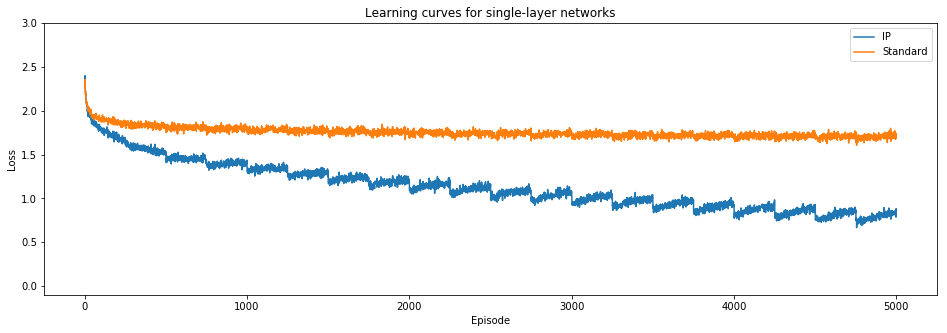

In [29]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for single-layer networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = net(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the standard network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = IPnet(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the IP network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

Accuracy of the standard network on the 10000 test images: 38.9400 %
Accuracy of the IP network on the 10000 test images: 49.2800 %
